# Lecture 7 Carbon Footprint Accounting


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline


## Page 01 - Measuring Carbon Emissions

![](pic/lecture7_carbon_footprint/page-01.png)


## Page 02 - Carbon Emissions Accounting Database: IPCC EFDB

![](pic/lecture7_carbon_footprint/page-02.png)


### Python practice ? Activity ? Emission Factor

A large fraction of carbon accounting can be written as:

$$\text{Emissions} = \text{Activity} \times \text{EF}$$

Below we compute a simple electricity example and convert **kg ? t**.


In [2]:
electricity_kwh = 10_000
grid_ef_kg_per_kwh = 0.5366

emissions_tco2e = electricity_kwh * grid_ef_kg_per_kwh / 1000
emissions_tco2e


5.366

## Page 03 - Carbon Emissions Accounting Database: National GHG EF Database

![](pic/lecture7_carbon_footprint/page-03.png)


## Page 04 - Key Industries in China's National Carbon Market

![](pic/lecture7_carbon_footprint/page-04.png)


## Page 05 - Scope 1: Power Generation Facilities Accounting Boundary

![](pic/lecture7_carbon_footprint/page-05.png)


## Page 06 - Scope 1: Fossil Fuel Combustion (Power Generation)

![](pic/lecture7_carbon_footprint/page-06.png)


### Python practice ? Scope 1 combustion formula

Slide formula (for each fuel $i$):

$$E_i = FC_i \times C_{ar,i} \times OF_i \times \frac{44}{12}$$

Where $44/12$ converts **C ? CO?**.


In [3]:
def combustion_emissions_tco2(fuels: pd.DataFrame) -> pd.DataFrame:
    out = fuels.copy()
    out['Emissions (tCO2)'] = out['FC'] * out['C_ar'] * out['OF'] * (44/12)
    return out

fuels_demo = pd.DataFrame({
    'Fuel': ['Fuel A', 'Fuel B'],
    'FC': [100.0, 50.0],
    'C_ar': [0.75, 0.85],
    'OF': [0.98, 0.99],
})

combustion_emissions_tco2(fuels_demo)


,Fuel,FC,C_ar,OF,Emissions (tCO2)
0,Fuel A,100.0,0.75,0.98,269.500
1,Fuel B,50.0,0.85,0.99,154.275


## Page 07 - Scope 1: Fuel Carbon Content (C_ar) Conversions

![](pic/lecture7_carbon_footprint/page-07.png)


### Python practice ? Moisture correction (C_ar)

We implement the moisture-correction formula to convert $C_{ad}$ to $C_{ar}$.


In [4]:
def carbon_as_received_from_air_dry(C_ad: float, M_ar: float, M_ad: float) -> float:
    return C_ad * (100 - M_ar) / (100 - M_ad)

C_ad = 0.75
M_ar = 12.0
M_ad = 5.0

carbon_as_received_from_air_dry(C_ad, M_ar, M_ad)


0.6947368421052632

## Page 08 - Scope 1 & 2 Practice: Power Generation Facilities

![](pic/lecture7_carbon_footprint/page-08.png)


### Python practice ? Replicate Page 08 totals

We replicate the slide using the energy-based method:

- **Scope 1**: fuel consumption ? LHV ? EF (tCO?/TJ)
- **Scope 2**: electricity (kWh) ? EF (kgCO?/kWh)


In [5]:
fuels = pd.DataFrame({
    'Fuel': ['Coke', 'Crude oil', 'Natural gas'],
    'Consumption': [20, 15, 10],
    'Unit': ['t', 't', '1e4 Nm?'],
    'LHV (TJ/unit)': [0.028, 0.041, 0.039],
    'EF (tCO2/TJ)': [107.1, 73.3, 56.1],
})

fuels['Energy (TJ)'] = fuels['Consumption'] * fuels['LHV (TJ/unit)']
fuels['Scope 1 (tCO2)'] = fuels['Energy (TJ)'] * fuels['EF (tCO2/TJ)']

scope1 = fuels['Scope 1 (tCO2)'].sum()

electricity_kwh = 10_000
grid_ef_kg_per_kwh = 0.5366
scope2 = electricity_kwh * grid_ef_kg_per_kwh / 1000

total = scope1 + scope2

fuels, scope1, scope2, total


(          Fuel  Consumption     Unit  LHV (TJ/unit)  EF (tCO2/TJ)  Energy (TJ)  Scope 1 (tCO2)
 0         Coke           20        t          0.028         107.1        0.560         59.9760
 1    Crude oil           15        t          0.041          73.3        0.615         45.0795
 2  Natural gas           10  1e4 Nm?          0.039          56.1        0.390         21.8790,
 np.float64(126.9345),
 5.366,
 np.float64(132.3005))

## Page 09 - Aluminum Making Process

![](pic/lecture7_carbon_footprint/page-09.png)


## Page 10 - Scope 1: Process Emissions (Aluminum Industry)

![](pic/lecture7_carbon_footprint/page-10.png)


### Python practice ? Aluminum process emissions

We implement the two components on the slide:

- CO? from anode consumption (raw material)
- CO?e from anode-effect gases (e.g., CF?, C?F?)

*The numbers below are illustrative; choose GWPs consistent with your reporting standard.*


In [6]:
def aluminum_raw_material_emissions_tco2(anode_consumption_t, nc_loss_ratio, sulfur_fraction, ash_fraction):
    carbon_t = anode_consumption_t * (1 - nc_loss_ratio) * (1 - sulfur_fraction - ash_fraction)
    return carbon_t * (44/12)

def aluminum_anode_effect_emissions_tco2e(aluminum_production_tAl, ef_cf4_kg_per_tAl, ef_c2f6_kg_per_tAl, gwp_cf4, gwp_c2f6):
    cf4_t = ef_cf4_kg_per_tAl * aluminum_production_tAl * 1e-3
    c2f6_t = ef_c2f6_kg_per_tAl * aluminum_production_tAl * 1e-3
    return cf4_t * gwp_cf4 + c2f6_t * gwp_c2f6

raw = aluminum_raw_material_emissions_tco2(anode_consumption_t=1000, nc_loss_ratio=0.05, sulfur_fraction=0.01, ash_fraction=0.02)
anode_effect = aluminum_anode_effect_emissions_tco2e(aluminum_production_tAl=50_000, ef_cf4_kg_per_tAl=0.02, ef_c2f6_kg_per_tAl=0.0011, gwp_cf4=6630, gwp_c2f6=11100)

pd.Series({'Raw material (tCO2)': raw, 'Anode effect (tCO2e)': anode_effect})


Raw material (tCO2)     3378.833333
Anode effect (tCO2e)    7240.500000
dtype: float64

## Page 11 - Scope 1 Practice: Aluminum Industry

![](pic/lecture7_carbon_footprint/page-11.png)


## Page 12 - Cement Manufacturing Process

![](pic/lecture7_carbon_footprint/page-12.png)


## Page 13 - Scope 1: Process Emissions (Cement Industry)

![](pic/lecture7_carbon_footprint/page-13.png)


### Python practice ? Cement clinker process emissions

We implement the clinker equation on the slide (base emissions minus deductions).


In [7]:
def cement_clinker_process_emissions_tco2(clinker_qty_t, clinker_ef_tco2_per_t, deductions=None):
    deductions = deductions or []  # list of (qty_t, deduction_ef_tco2_per_t)
    base = clinker_qty_t * clinker_ef_tco2_per_t
    deduction = sum(qty * ef for qty, ef in deductions)
    return base - deduction

cement_clinker_process_emissions_tco2(
    clinker_qty_t=1_000_000,
    clinker_ef_tco2_per_t=0.52,
    deductions=[(50_000, 0.10)],
)


515000.0

## Page 14 - Scope 1 Practice: Cement Industry

![](pic/lecture7_carbon_footprint/page-14.png)


## Page 15 - Steel Making Process

![](pic/lecture7_carbon_footprint/page-15.png)


## Page 16 - Scope 1: Process Emissions (Iron & Steel Industry)

![](pic/lecture7_carbon_footprint/page-16.png)


### Python practice ? Net process emissions (inputs minus outputs)

A simplified way to mirror the slide logic is:

$$\text{Net emissions} = \sum \text{inputs} - \sum \text{outputs}$$

In energy terms: emissions = energy (TJ) ? EF (tCO?/TJ).


In [8]:
def tco2_from_energy(energy_TJ, ef_tco2_per_TJ):
    return energy_TJ * ef_tco2_per_TJ

inputs = pd.DataFrame({'Stream': ['Input fuel'], 'Energy (TJ)': [1000], 'EF (tCO2/TJ)': [94.6]})
outputs = pd.DataFrame({'Stream': ['By-product gas'], 'Energy (TJ)': [150], 'EF (tCO2/TJ)': [56.1]})

inputs['tCO2'] = inputs.apply(lambda r: tco2_from_energy(r['Energy (TJ)'], r['EF (tCO2/TJ)']), axis=1)
outputs['tCO2'] = outputs.apply(lambda r: tco2_from_energy(r['Energy (TJ)'], r['EF (tCO2/TJ)']), axis=1)

net = inputs['tCO2'].sum() - outputs['tCO2'].sum()
inputs, outputs, net


(       Stream  Energy (TJ)  EF (tCO2/TJ)     tCO2
 0  Input fuel         1000          94.6  94600.0,
            Stream  Energy (TJ)  EF (tCO2/TJ)    tCO2
 0  By-product gas          150          56.1  8415.0,
 np.float64(86185.0))

## Page 17 - Case Study

![](pic/lecture7_carbon_footprint/page-17.png)


## Page 18 - Background of Company X

![](pic/lecture7_carbon_footprint/page-18.png)


## Page 19 - Company X's Organizational Boundary

![](pic/lecture7_carbon_footprint/page-19.png)


## Page 20 - Company X's Emissions Sources

![](pic/lecture7_carbon_footprint/page-20.png)


## Page 21 - Emissions from Solid Waste

![](pic/lecture7_carbon_footprint/page-21.png)


### Python practice ? Solid waste (Page 21)

We replicate the slide using **activity (t)** ? **EF (kgCO?e/t)**, then convert kg ? t.


In [9]:
# HQ solid waste
hq = pd.DataFrame({
    'Garbage subclass': ['Food waste (wet)', 'Separate waste (dry)'],
    '240L barrels (count)': [646, 7436],
    'Weight per 240L barrel (kg)': [117.12, 117.12],
    'EF (kgCO2e/t)': [4.44, -53.01],
})
hq['Activity (t)'] = hq['240L barrels (count)'] * hq['Weight per 240L barrel (kg)'] / 1000
hq['Emissions (tCO2e)'] = hq['Activity (t)'] * hq['EF (kgCO2e/t)'] / 1000

hq_total = hq['Emissions (tCO2e)'].sum()

hq, hq_total


(       Garbage subclass  240L barrels (count)  Weight per 240L barrel (kg)  EF (kgCO2e/t)  Activity (t)  \
 0      Food waste (wet)                   646                       117.12           4.44      75.65952   
 1  Separate waste (dry)                  7436                       117.12         -53.01     870.90432   
 
    Emissions (tCO2e)  
 0           0.335928  
 1         -46.166638  ,
 np.float64(-45.8307097344))

In [10]:
# Other employees (note: the slide combines 1.4 + 0.115 kg/person?d)
other = pd.DataFrame({
    'People': [18980],
    'Household garbage (kg/person?d)': [1.4],
    'Food waste (kg/person?d)': [0.115],
    'Working days (d)': [250],
    'EF (kgCO2e/t)': [353.19],
})

other['Activity (t)'] = other['People'] * (other['Household garbage (kg/person?d)'] + other['Food waste (kg/person?d)']) * other['Working days (d)'] / 1000
other['Emissions (tCO2e)'] = other['Activity (t)'] * other['EF (kgCO2e/t)'] / 1000

other


,People,Household garbage (kg/person?d),Food waste (kg/person?d),Working days (d),EF (kgCO2e/t),Activity (t),Emissions (tCO2e)
0,18980,1.4,0.115,250,353.19,7188.675,2538.968123


## Page 22 - Emissions from Business Travel

![](pic/lecture7_carbon_footprint/page-22.png)


### Python practice ? Business travel (Page 22)

Emissions = distance (person?km) ? EF (kgCO?e/person?km), then kg ? t.


In [11]:
travel = pd.DataFrame({
    'Mode': ['Car', 'Air', 'Train'],
    'Distance (person?km)': [1_987_931, 25_696_963, 9_712_201],
    'EF (kgCO2e/person?km)': [0.028, 0.088, 0.018],
})

travel['Emissions (tCO2e)'] = travel['Distance (person?km)'] * travel['EF (kgCO2e/person?km)'] / 1000

travel, travel['Emissions (tCO2e)'].sum()


(    Mode  Distance (person?km)  EF (kgCO2e/person?km)  Emissions (tCO2e)
 0    Car               1987931                  0.028          55.662068
 1    Air              25696963                  0.088        2261.332744
 2  Train               9712201                  0.018         174.819618,
 np.float64(2491.81443))

## Page 23 - Emissions from Employee Commuting

![](pic/lecture7_carbon_footprint/page-23.png)


### Python practice ? Employee commuting (Page 23)

We replicate both parts on the slide: (1) mode-based bottom-up for HQ staff; (2) city-level factor for other employees (round-trip).


In [12]:
# HQ staff
hq_commute = pd.DataFrame({
    'Mode': ['Self-driving', 'Public'],
    'Distance (person?km)': [1_335_000, 5_340_000],
    'EF (kgCO2e/person?km)': [0.041, 0.015],
})

hq_commute['Emissions (tCO2e)'] = hq_commute['Distance (person?km)'] * hq_commute['EF (kgCO2e/person?km)'] / 1000

hq_commute, hq_commute['Emissions (tCO2e)'].sum()


(           Mode  Distance (person?km)  EF (kgCO2e/person?km)  Emissions (tCO2e)
 0  Self-driving               1335000                  0.041             54.735
 1        Public               5340000                  0.015             80.100,
 np.float64(134.83499999999998))

In [13]:
# Other employees
people = 18_980
ef_tco2_per_10k_person_day_one_way = 5.70
working_days = 250

other_employees_commuting = ef_tco2_per_10k_person_day_one_way * (people/10_000) * working_days * 2
other_employees_commuting


5409.3

## Page 24 - Emissions from Logistics

![](pic/lecture7_carbon_footprint/page-24.png)


### Python practice ? Logistics (Page 24)

Emissions = distance (t?km) ? EF (kgCO?e/t?km), then kg ? t.


In [14]:
t_km = 42_303
ef_kg_per_t_km = 0.414

emissions = t_km * ef_kg_per_t_km / 1000
emissions


17.513441999999998

In [15]:
# If you want to match the slide's reported 17.499 tCO2e exactly,
# you can compute the implied EF (the slide likely rounded inputs).
target = 17.499
implied_ef = target * 1000 / 42_303
implied_ef


0.41365860577264024

## Page 25 - Total Scope 3 Emissions

![](pic/lecture7_carbon_footprint/page-25.png)


### Python practice ? Scope 1/2/3 shares (Page 25)

The slide table is in **10,000 tons**. We reproduce it and plot the shares.


In [16]:
emissions_10k_tons = pd.Series({'Scope 1': 6.57, 'Scope 2': 36.20, 'Scope 3': 71.94})
total_10k = emissions_10k_tons.sum()
shares = emissions_10k_tons / total_10k

summary = pd.DataFrame({'Emissions (10k tons)': emissions_10k_tons, 'Share': shares})
summary.loc['Total'] = [total_10k, 1.0]

summary


,Emissions (10k tons),Share
Scope 1,6.57,0.057275
Scope 2,36.20,0.315578
Scope 3,71.94,0.627147
Total,114.71,1.000000


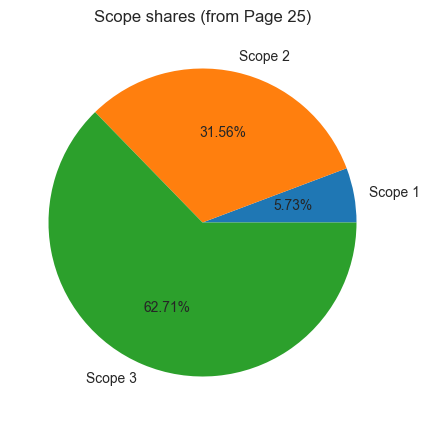

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(shares, labels=shares.index, autopct=lambda p: f'{p:.2f}%')
ax.set_title('Scope shares (from Page 25)')
plt.show()


## Page 26 - Analysis of Company X's Scope 3 Emissions

![](pic/lecture7_carbon_footprint/page-26.png)


### Python practice ? Scope 3 composition (Page 26)

We reconstruct the percentage breakdown on the slide and convert shares into tonnage.


In [18]:
scope3_total = 719_400

major = pd.Series({'Lease (consigned malls)': 0.6978, 'Franchise': 0.2229, 'Other': 0.0794})
major_tons = (major * scope3_total).round(0).astype(int)

minor = pd.Series({
    'Upstream & downstream energy': 0.0585,
    'Employee commuting': 0.0077,
    'Purchased products & services': 0.0054,
    'Business trip': 0.0042,
    'Solid waste': 0.0035,
    'Logistics transportation': 0.0001,
})
minor_tons = (minor * scope3_total).round(0).astype(int)

major_tons, minor_tons


(Lease (consigned malls)    501997
 Franchise                  160354
 Other                       57120
 dtype: int64,
 Upstream & downstream energy     42085
 Employee commuting                5539
 Purchased products & services     3885
 Business trip                     3021
 Solid waste                       2518
 Logistics transportation            72
 dtype: int64)

## Page 27 - Financed Emissions

![](pic/lecture7_carbon_footprint/page-27.png)


## Page 28 - Carbon Emissions for Financial Institutions

![](pic/lecture7_carbon_footprint/page-28.png)


## Page 29 - GHG Protocol vs PCAF: Requirements Comparison

![](pic/lecture7_carbon_footprint/page-29.png)


## Page 30 - Financial Institutions' Disclosure Metrics

![](pic/lecture7_carbon_footprint/page-30.png)


## Page 31 - Financed Emissions Calculation Methodology (PCAF)

![](pic/lecture7_carbon_footprint/page-31.png)


### Python practice ? Financed emissions basics (Page 31)

Core idea (PCAF):

$$\text{Financed emissions} = \text{Attribution factor} \times \text{Investee emissions}$$

For listed companies, attribution often uses **EVIC**.


In [19]:
def evic(market_cap, preferred_stock, debt, minority_interest):
    return market_cap + preferred_stock + debt + minority_interest

def financed_emissions(ghg_emissions, outstanding_amount, base_value):
    return (outstanding_amount / base_value) * ghg_emissions

# Example: one listed investee
ghg = 1_000_000  # tCO2e
outstanding = 50_000_000
base = evic(market_cap=200_000_000, preferred_stock=0, debt=100_000_000, minority_interest=0)

financed_emissions(ghg, outstanding, base)


166666.66666666666

## Page 32 - Example: Mortgage-related GHG Emissions

![](pic/lecture7_carbon_footprint/page-32.png)


## Page 33 - Formula: Attribution of Emissions (Mortgage)

![](pic/lecture7_carbon_footprint/page-33.png)


### Python practice ? Mortgage attribution (Page 33)

For mortgages, attribution is often the loan share of the property's value at origination.


In [20]:
mortgages = pd.DataFrame({
    'Building': ['Sears Tower', 'Empire State Building', 'Salesforce Tower'],
    'Outstanding ($)': [1_000_000, 14_000_000, 0],
    'Property value at origination ($)': [2_000_000, 15_000_000, 1_000_000],
    'Building emissions (tCO2e)': [10_000, 20_000, 5_000],
})

mortgages['Attribution factor'] = mortgages['Outstanding ($)'] / mortgages['Property value at origination ($)']
mortgages['Financed emissions (tCO2e)'] = mortgages['Attribution factor'] * mortgages['Building emissions (tCO2e)']

mortgages


,Building,Outstanding ($),Property value at origination ($),Building emissions (tCO2e),Attribution factor,Financed emissions (tCO2e)
0,Sears Tower,1000000,2000000,10000,0.500000,5000.000000
1,Empire State Building,14000000,15000000,20000,0.933333,18666.666667
2,Salesforce Tower,0,1000000,5000,0.000000,0.000000


## Page 34 - Compute Building Emissions

![](pic/lecture7_carbon_footprint/page-34.png)


### Python practice ? Building emissions from energy (Page 34)

We compute building emissions from energy consumption and emission factors.


In [21]:
def building_emissions_from_energy(energy, ef):
    # energy: {source: amount}, ef: {source: kgCO2e per unit}
    total_kg = 0.0
    for src, amt in energy.items():
        total_kg += amt * ef.get(src, 0.0)
    return total_kg / 1000  # tCO2e

energy = {'electricity_MWh': 300, 'natural_gas_m3': 40_000}
ef = {'electricity_MWh': 853, 'natural_gas_m3': 2.0}

building_emissions_from_energy(energy, ef)


335.9

## Page 35 - Data Quality (PCAF)

![](pic/lecture7_carbon_footprint/page-35.png)


## Page 36 - Score 1 & 2 Data (Metered Energy)

![](pic/lecture7_carbon_footprint/page-36.png)


## Page 37 - Practice: Chicago Office Building

![](pic/lecture7_carbon_footprint/page-37.png)


## Page 38 - Practice: Worked Solution (Option 1A)

![](pic/lecture7_carbon_footprint/page-38.png)


### Python practice ? Chicago office building (Pages 37?38)

We compute the financed emissions using the inputs shown on Page 37.

If your result differs from the circled value on Page 38, double-check units and note that slide decks can contain arithmetic typos.


In [22]:
loan = 50_000_000
property_value = 100_000_000
attribution = loan / property_value

energy = {'electricity_MWh': 300, 'natural_gas_m3': 40_000}
ef = {'electricity_MWh': 853, 'natural_gas_m3': 2.0}

property_emissions_t = building_emissions_from_energy(energy, ef)
financed_t = attribution * property_emissions_t

pd.Series({
    'Attribution factor': attribution,
    'Property emissions (tCO2e)': property_emissions_t,
    'Financed emissions (tCO2e)': financed_t,
    'Financed emissions (kgCO2e)': financed_t * 1000,
})


Attribution factor                  0.50
Property emissions (tCO2e)        335.90
Financed emissions (tCO2e)        167.95
Financed emissions (kgCO2e)    167950.00
dtype: float64

## Page 39 - Score 3 & 4 Data (Floor Area)

![](pic/lecture7_carbon_footprint/page-39.png)


## Page 40 - Practice: Belgium Single-Family Home (Option 2A)

![](pic/lecture7_carbon_footprint/page-40.png)


## Page 41 - Practice: Worked Solution (Option 2A)

![](pic/lecture7_carbon_footprint/page-41.png)


### Python practice ? Belgium home (Pages 40?41)

This example uses emission factors in **tCO?e per m?** (already aggregated by scope).


In [23]:
loan = 150_000
property_value = 1_000_000
attribution = loan / property_value

floor_area_m2 = 100
ef_scope1_t_per_m2 = 0.002
ef_scope2_t_per_m2 = 0.0076

property_emissions_t = floor_area_m2 * (ef_scope1_t_per_m2 + ef_scope2_t_per_m2)
financed_t = attribution * property_emissions_t

pd.Series({
    'Attribution factor': attribution,
    'Property emissions (tCO2e)': property_emissions_t,
    'Financed emissions (tCO2e)': financed_t,
})


Attribution factor            0.150
Property emissions (tCO2e)    0.960
Financed emissions (tCO2e)    0.144
dtype: float64

## Page 42 - Score 5 Data (Number of Buildings)

![](pic/lecture7_carbon_footprint/page-42.png)


## Page 43 - Practice: California Food Service Building (Option 3)

![](pic/lecture7_carbon_footprint/page-43.png)


## Page 44 - Practice: Worked Solution (Option 3)

![](pic/lecture7_carbon_footprint/page-44.png)


### Python practice ? California food-service building (Pages 43?44)

This example uses emission factors in **tCO?e per building**.


In [24]:
loan = 780_000
property_value = 780_000
attribution = loan / property_value

ef_scope1_t_per_building = 22.98
ef_scope2_t_per_building = 35.96

property_emissions_t = ef_scope1_t_per_building + ef_scope2_t_per_building
financed_t = attribution * property_emissions_t

pd.Series({
    'Attribution factor': attribution,
    'Property emissions (tCO2e)': property_emissions_t,
    'Financed emissions (tCO2e)': financed_t,
})


Attribution factor             1.00
Property emissions (tCO2e)    58.94
Financed emissions (tCO2e)    58.94
dtype: float64

## Page 45 - Additional: PBoC Methodology for Financial Institutions

![](pic/lecture7_carbon_footprint/page-45.png)
